# Flat-<i>k</i> Gaussian <i>P(k)</i>

Bobby Pascua and the HERA Validation Team

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Flat-k-Gaussian-P(k)" data-toc-modified-id="Flat-k-Gaussian-P(k)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Flat-<i>k</i> Gaussian <i>P(k)</i></a></span><ul class="toc-item"><li><span><a href="#Setup-and-Metadata" data-toc-modified-id="Setup-and-Metadata-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Setup and Metadata</a></span><ul class="toc-item"><li><span><a href="#Abstract" data-toc-modified-id="Abstract-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Abstract</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Description" data-toc-modified-id="Description-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Software" data-toc-modified-id="Software-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Software</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-1.1.6"><span class="toc-item-num">1.1.6&nbsp;&nbsp;</span>Data</a></span></li></ul></li><li><span><a href="#Data-Retrieval" data-toc-modified-id="Data-Retrieval-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data Retrieval</a></span><ul class="toc-item"><li><span><a href="#Power-Spectrum-Retrieval" data-toc-modified-id="Power-Spectrum-Retrieval-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Power Spectrum Retrieval</a></span></li><li><span><a href="#Power-Spectrum-Amplitude-Expectation" data-toc-modified-id="Power-Spectrum-Amplitude-Expectation-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Power Spectrum Amplitude Expectation</a></span></li></ul></li><li><span><a href="#Data-Visualization" data-toc-modified-id="Data-Visualization-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Data Visualization</a></span><ul class="toc-item"><li><span><a href="#Ensemble-Averaged-Power-Spectrum" data-toc-modified-id="Ensemble-Averaged-Power-Spectrum-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Ensemble-Averaged Power Spectrum</a></span></li><li><span><a href="#Histograms" data-toc-modified-id="Histograms-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Histograms</a></span></li></ul></li></ul></li></ul></div>

## Setup and Metadata

### Abstract

This notebook validates the `hera_pspec.pspecdata` pipeline's ability to recover a flat-<i>k</i> Gaussian power spectrum from an ensemble of noiseless simulations. We extract the power spectrum estimate from each simulation using the `hera_pspec.pspecdata` pipeline and perform an ensemble average on the resulting spectra. We find agreement between the measured and predicted power spectrum amplitude to better than 0.2%. Additionally, we histogram the measured powers from the full ensemble and find that the distribution is consistent with an exponential distribution, with the scale parameter given by the expected power spectrum amplitude.

### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import glob
import re
import multiprocessing as mp
from IPython.utils import io
from datetime import datetime

import hera_pspec as hp
from pyuvdata import UVData
import pyuvdata
import os, sys

In [2]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

### Description

Last executed: 2019-07-08 20:36:42.167550

- **Major Step Description:** Simulate sky-locked, white-spectrum Gaussian field and estimate power spectrum with `hera_pspec.pspecdata`
- **Minor Variation Description:** Generate flat-k, sky-locked Gaussian field and estimate power spectrum from an ensemble average.
- **Pipelines Tested:** `hera_pspec.pspecdata`
- **Criteria**:
  1. Ensemble averaged power spectrum agrees with analytic prediction to within the predicted mean standard error.
  

### Summary

The results of this validation test, in reference to the outlined criteria, are
1. Test passed; ensemble averaged power spectrum estimate agrees with analytic expectation to better than 0.2%

The ensemble of power spectrum estimates was histogrammed and the result nearly perfectly follows an exponential distribution with scale parameter set by the expected power spectrum amplitude.

### Software

HERA software used in this validation test, with associate git commit hash:

* ``hera_pspec``: ``4a877f16c9c899affa656926461f37bca6683dcc``
* ``pyuvdata``: ``d1829efacb60da384f64a8f25a280441bfa9d68a``

Versions of other software used in this validation test:

* ``numpy``: ``v1.14.3``
* ``matplotlib``: ``v2.2.3``
* ``multiprocessing``: ``v0.70a1``
* ``re``: ``v2.2.1``

### Data

The following paths reflect the exact locations of all data used in this test:

In [3]:
sim_path = "/lustre/aoc/projects/hera/alanman/eor_sky_sim/"
spec_path = "/lustre/aoc/projects/hera/Validation/test-0.1.0/Spectra/"
config_path = "/lustre/aoc/projects/hera/Validation/test-0.1.0/config_files/"

## Data Retrieval



### Power Spectrum Retrieval

This section offers two methods of retrieving the ensemble of power spectra: the first is by loading in the pre-processed power spectra, while the second involves obtaining the power spectra from the visibility data.

In [4]:
# try to make a glob of the pre-processed files, make glob of sim files if not
try:
    dfiles = sorted(glob.glob('{}eor*.npz'.format(spec_path)))
    data = np.load(dfiles[0])['arr_0']
    print('Preprocessed files found. Now histogramming powers and computing ensemble averaged spectrum.')
    prepro = True
except:
    dfiles = sorted(glob.glob('{}*24.*.uvh5'.format(sim_path)))
    print('Preprocessed files not found. Now beginning power spectrum extraction.')
    print('WARNING: This process may take up to 30 hours. To speed up the process, ensure \
           \nthat your interactive job has requested multiple processors per node and sufficient \
           \nmemory. We recommend at least 5 processors and 64 GB memory.')
    prepro = False

Preprocessed files found. Now histogramming powers and computing ensemble averaged spectrum.


In [5]:
# either way, we want to make a histogram, so let's define the bin edges
bins = np.linspace(0, 1e7, 49)

# if pre-processed files can't be found, then we need to process the simulation files
if not prepro:
    # if we can't find the pre-processed files, then they must not be on the cluster
    # so let's just process all the files and save them
    
    # define a function that accepts an input uvh5 file, calculates the power spectrum,
    # and saves the result in a PSpecContainer object
    def calc_pspec(infile):
        # use regular expressions to get simulation number
        p1 = re.compile('\d+.uvh5')
        substr = p1.findall(infile)[0]
        p2 = re.compile('\d+')
        fnum = p2.findall(substr)[0]
        # make name for PSpecContainer save file
        outfile = '{}eorsky_spec{}'.format(spec_path,fnum)
        
        # initialize UVData object and load infile
        uvd = UVData()
        # read data file, but suppress message about eorsky not being a known telescope
        with io.capture_output() as captured:
            uvd.read_uvh5(infile)
        
        # define the cosmology
        cosmo = hp.conversions.Cosmo_Conversions()
        
        # get parameters for making a Gaussian beam
        bm_fwhm = np.radians(uvd.extra_keywords[u'bm_fwhm'])
        freqs = np.unique(uvd.freq_array)
        
        # make the beam
        beam = hp.PSpecBeamGauss(bm_fwhm, freqs, cosmo=cosmo)
        
        # make blpairs using only autopairs
        bls = uvd.get_antpairs()
        blpairs = zip(bls, bls)
            
        # define tapers to be used
        tapers = ['blackman-harris', 'none']
        
        # make sure output is in temperature units
        Jy2mK = uvd.vis_units.upper()=='JY'
        
        # calculate the spectra with pspec_run for each taper
        for taper in tapers:
            # update outfile name
            outfile = '{}_{}.psc'.format(outfile, taper)
            
            # capture the output from when Jy2mK is asked to act on a dset already set
            # to mK units
            with io.capture_output() as captured:
                # get power spectrum
                psc, ds = hp.pspecdata.pspec_run([uvd,uvd], outfile, blpairs=blpairs,
                                                 taper=taper, beam=beam, cosmo=cosmo,
                                                 Jy2mK=Jy2mK, verbose=False)
        return 0
    
    # now process the files in parallel
    if __name__=='__main__':
        # get the user name to retrieve number of processors requested for job
        user = !whoami
        user = user[0]
        
        # assume everyone follows the guidelines for using jupyter notebooks
        # and assume that an interactive job using multiple processors is run
        # using the job scheduler
        try:
            jn_pbs_path = '/users/{}/jupyter_notebook.pbs'.format(user)
        except:
            print('Please set up a jupyter_notebook.pbs script in your personal directory.')
            sys.exit()
        with open(jn_pbs_path) as jn_pbs_file:
            # read the contents of the .pbs script
            text = jn_pbs_file.read()
            
            # use regular expressions to find the number of processors requested
            p1 = re.compile('nodes=\d+')
            p2 = re.compile('ppn=\d+')
            p3 = re.compile('\d+')
            
            nodes = int(p3.findall(p1.findall(text)[0])[0])
            ppn = int(p3.findall(p2.findall(text)[0])[0])
            
            # check that the interactive job has enough memory requested, since
            # each instance of an opened uvh5 file via UVData requires approx
            # 2 GB of memory
            p1 = re.compile('vmem=\d+G')
            mem = int(p3.findall(p1.findall(text)[0])[0])

            
        # choose number of processors such that there won't be a MemoryError,
        # but also such that at least one processor is used
        Nprocs = max(1,min(mem/4 - nodes, nodes*(ppn - 1)))
        # note that there are times in the pspec pipeline where the data is copied
        # before it is discarded; this can cause memory spikes up to Nprocs * 4 GB
        # when the pspec pipeline is run in parallel over Nprocs processors

        # start pool of workers
        pool = mp.Pool(Nprocs)
        # process files in parallel
        pool.map(calc_pspec, dfiles)
        # close the pool
        pool.close()
        
    # now that the files have been processed, let's retrieve the ensemble averaged pspec
    
    # first, define some things for some clarity on what's happening
    # first, load in one of the simulation files
    uvd = UVData()
    uvd.read_uvh5(dfiles[np.random.randint(low=0,high=len(dfiles))])
    
    # next, define the tapers used in this analysis
    tapers = ['blackman-harris', 'none']
    
    # now get the baseline pairs; these are (0,11), (0,12), (11,12)
    bls = uvd.get_antpairs()
    blpairs = zip(bls,bls)
    
    # get the size of the time array
    Ntimes = len(np.unique(uvd.time_array))
    
    # get the size of the frequency array
    Nfreqs = len(np.unique(uvd.freq_array))
    
    # initialize an array to hold the averaged spectrum
    avg_spec = np.zeros( (len(tapers), len(blpairs), Ntimes, Nfreqs), dtype='complex128' )
    
    # also initialize an array for the histograms
    hist = np.zeros( (len(tapers), len(blpairs), len(bins)-1), dtype='float64' )
    
    # loop over tapers
    for i, taper in enumerate(tapers):
        # make glob of data files
        specfiles = sorted(glob.glob('{}*{}.psc'.format(path1, taper)))
        
        # now loop over files
        for f in specfiles:
            # load PSpecContainer object
            psc = hp.container.PSpecContainer(f)
            
            # get UVPSpec object from pspec container
            uvp = psc.get_pspec(psc.groups()[0])[0]
            
            # loop over baseline pairs
            for j, blp in enumerate(blpairs):
                # make key to get pspec
                # we used the full spectral range, so spw = 0
                # all of the data has polarization pI
                key = (0, blp, 'pI')
                
                # retrieve the power spectrum
                pspec = uvp.get_data(key)
                
                # add it to the ensemble average array
                avg_spec[i,j] += pspec
                
                # update the histogram
                hist[i,j] += np.histogram(pspec.real, bins=bins)[0]
                
                # normalize the histogram
                hist[i,j] /= hist[i,j].sum()
                            
    # divide out by the number of files for the ensemble average
    avg_spec /= len(dfiles)
    
else:
    # get the ensemble average and fill out the histogram
    
    # first, make an array of zeros for the ensemble average
    avg_spec = np.zeros(data.shape, dtype='complex128')
    
    # since we were able to load in the pre-processed files, let's make
    # histograms for spectra computed with and without a taper
    hist = np.zeros( (2, 3,len(bins)-1), dtype='float64')
    
    # we'll need to loop over data files
    for dfile in dfiles:
        # load in the data
        data = np.load(dfile)['arr_0']
        
        # add it to the average spectrum, to be divided by the number of realizations
        # later on in the script
        avg_spec += data
        
        # update the histograms, but do this on a per-baseline basis
        # we need to take the abs of the data first for histogramming
        data = np.abs(data)
        # from the README, axis-1 corresponds to baselines
        for j in range(data.shape[1]):
            # axis-0 corresponds to taper choice
            # data[0] -> bh-taper
            # data[1] -> no taper
            hist[0,j] += np.histogram(data[1,j], bins=bins)[0]
            hist[1,j] += np.histogram(data[0,j], bins=bins)[0]
            
    # we're done with our loops, so now divide the average spectrum array by the 
    # number of realizations
    avg_spec /= len(dfiles)
    
    # let's normalize the histograms while we're at it
    for j in range(hist.shape[1]):
        hist[0,j] /= hist[0,j].sum()
        hist[1,j] /= hist[1,j].sum()

### Power Spectrum Amplitude Expectation

In this section, we determine the expected amplitude of the power spectrum. The expected amplitude is given by $P_0 = \sigma^2\Delta\nu\Delta\Omega X^2Y$, where $\sigma^2$ is the variance of the sky-locked, spectrally-flat Gaussian distribution of 21-cm brightness temperature fluctuations; $\Delta\nu$ is the size of a frequency channel; $\Delta\Omega$ is the size of a pixel in the HEALPix map used for the simulation, given by $\Delta\Omega = 4\pi/(12N_{side}^2)$; $X$ and $Y$ are cosmological scalars, used in the usual sense, evaluated at the redshift of the 21-cm line at band-center.

In [6]:
# get a glob of simulation files and choose one at random
dfile = glob.glob('{}*24*.uvh5'.format(sim_path))[0]

# instantiate a UVData object and read the data file
uvd = UVData()
with io.capture_output() as captured:
    # read data file, but suppress warning message
    uvd.read_uvh5(dfile)
    
# print the file history
print(uvd.history)

# get the parameters needed to compute the expected amplitude of the power spectrum
nside = uvd.extra_keywords[u'nside']
dOmega = 4*np.pi/(12*nside**2)                 # sr
skysig = uvd.extra_keywords[u'skysig'] * 1e3   # mK
df = np.diff(np.unique(uvd.freq_array)).mean() # Hz
f0 = 1420405751.767         # HI rest-frequency, Hz
z = f0/np.median(np.unique(uvd.freq_array)) - 1 # redshift of HI line at band-center
X2Y = hp.conversions.Cosmo_Conversions().X2Y(z) # (h^-1 Mpc)^3 sr^-1 Hz^-1

# calculate expected power spectrum amplitude
P0 = skysig**2*df*dOmega*X2Y                    # mK^2 h^-3 Mpc^3

**uvd.history output** (slightly formatted):  
  
  Read/written with pyuvdata version: 1.3.5.  
  Git origin: https://github.com/HERA-Team/pyuvdata.git.  
  Git hash: 63b641eaa25f80800d4d4e878ed70fa1857348f2.  
  Git branch: redundancy_bugfix.  
  Git description: v1.3-261-g63b641e.  
  Read/written with pyuvdata version: 1.3.8.  
  Git origin: git@github.com:RadioAstronomySoftwareGroup/pyuvdata.git.  
  Git hash: a25500c899af73e1c1cdf08deceeddf9b54c5aeb.  
  Git branch: master.  
  Git description: v1.3-521-ga25500c.

**Simulation configuration file contents:**
<pre>
filing:  
  outdir: "./eorsky_out/mwa_three_short_bl_30mk"  
  clobber: False  
freq:  
  Nfreqs: 384  
  start_freq: 100000000.0  
  bandwidth:  30000000.0  
telescope:  
  array_layout: telescope_config/HERA65_layout.csv  
  telescope_config_name: telescope_config/MWA65_config.yaml  
sources:  
  catalog: 'gaussian_eor_shell'  
time:  
  Ntimes: 7854   # 24 hours  
  #Ntimes: 100   # 24 hours  
  integration_time: 11.0  
  start_time: 2458098.5521759833  
select:  
  bls: '[(0,11),(0,12),(11,12)]'  
  
fov: 110   # Deg  
Nskies: 10  
sky_sigma: 0.031      # mwaK  
Nside: 128  
</pre>

**Telescope configuration file contents:**

<pre>  
Nants: 65  
beam_paths:  
  0: 'gaussian'  
sigma: 0.089897  
telescope_location: (-30.72152777777791, 21.428305555555557, 1073.0000000093132)
#telescope_location: (-30.721526120689507, 21.42830382686302, 1051.690000018105)  
telescope_name: HERA  
</pre>

## Data Visualization

In this section, we visualize the data collected in the previous section. We compare the ensemble-averaged power spectra to the expected power spectrum amplitude on a per-baseline basis, and we also examine the result averaged over baselines. We conclude the section by displaying the histograms calculated above, again on a per-baseline basis.

### Ensemble-Averaged Power Spectrum

In [7]:
# calculate the difference in the beam-squared integral (between the simulation and the
# analytic result for a Gaussian beam), and get the delays for the power spectrum

# define the cosmology
cosmo = hp.conversions.Cosmo_Conversions()

# get the beam fwhm
bm_fwhm = np.radians(uvd.extra_keywords[u'bm_fwhm'])

# make the beam object
uvb = hp.PSpecBeamGauss(fwhm=bm_fwhm, beam_freqs=np.unique(uvd.freq_array), cosmo=cosmo)

# get the beam-squared integral from the extra keywords and calculate it with hera_pspec
bsq_int = uvd.extra_keywords[u'bsq_int']
bsq_int_hp = uvb.power_beam_sq_int(pol='pI').mean()

# get the difference in the beam-squared integral
# hera_pspec uses the analytic result, so we'll take that as the reference
# for the correct value
bsq_int_diff = bsq_int_hp - bsq_int
bsq_int_diff_pct = 100*bsq_int_diff/bsq_int_hp

# use hera_pspec.utils.get_delays to get the delays
dlys = hp.utils.get_delays(np.unique(uvd.freq_array)) * 1e9 # ns

# make a list of baselines
bls = uvd.get_antpairs()

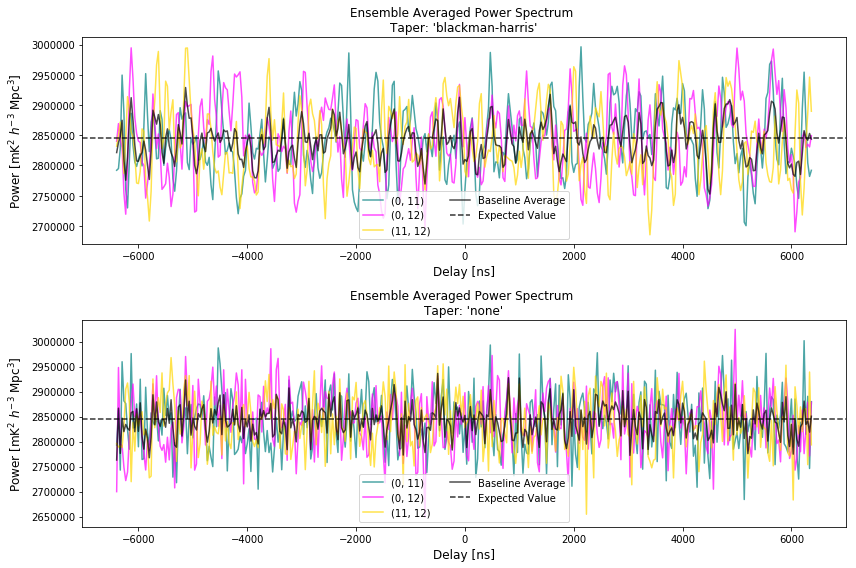

In [8]:
# average the results over time (axis-2) and plot the resulting delay spectrum for
# each baseline, as well as the baseline-averaged result. for bonus points, include
# a smaller figure with each plot showing the residual?
time_avg_spec = avg_spec.mean(axis=2)
bl_avg_spec = time_avg_spec.mean(axis=1)

colors = ['teal', 'magenta', 'gold']
tapers = ['blackman-harris', 'none']

fig = plt.figure(figsize=(12,8))
axes = fig.subplots(2,1)
for j, taper in enumerate(tapers):
    # label axes
    axes[j].set_xlabel('Delay [ns]', fontsize=12)
    axes[j].set_ylabel(r'Power [mK$^2$ $h^{-3}$ Mpc$^3$]', fontsize=12)
    axes[j].set_title("Ensemble Averaged Power Spectrum \nTaper: '{}'".format(taper), fontsize=12)

    # plot spectra for each baseline
    for k, bl in enumerate(bls):
        axes[j].plot(dlys, time_avg_spec[j,k].real, color=colors[k], alpha=0.7, label=bl)
    
    # plot baseline-averaged spectrum
    axes[j].plot(dlys, bl_avg_spec[j].real, color='k', alpha=0.7, label='Baseline Average')
    
    # plot expected amplitude
    axes[j].axhline(P0, ls='--', color='k', alpha=0.8, label='Expected Value')
    
    # make a legend
    axes[j].legend(ncol=2)

# show the plot
plt.tight_layout()
plt.show()

**Figure 1 |** Time-averaged delay spectra of the ensemble-averaged power spectrum, plotted by baseline and compared to the baseline-average. The horizontal dashed line shows the expected power spectrum amplitude. The top plot shows the results calculated using a Blackman-Harris taper, whereas the bottom plot shows results calculated using no taper. Visually, the ensemble-averaged power spectrum looks to give a very good estimate of the actual power spectrum simulated, regardless of the taper used; see the output of the following cell for a breakdown of the discrepancies.

In [9]:
# show the discrepancy in the results numerically

# calculate estimated power spectrum amplitudes
avg_spec_amps = time_avg_spec.mean(axis=-1)

# loop over tapers
for j, taper in enumerate(tapers):
    # loop over baselines
    for k, bl in enumerate(bls):
        disc = 100*(P0 - avg_spec_amps[j,k])/P0
        print("\nDiscrepancy for baseline {} with taper '{}': {:4.3f}%".format(bl, taper, disc.real))
    
    # show discrepancy for baseline-averaged results
    disc = 100*(P0 - avg_spec_amps[j].mean())/P0
    print("\nDiscrepancy for baseline-average with taper '{}': {:4.3f}%".format(taper, disc.real))
    
# for reference, show discrepancy in beam-squared integral
print('\nDiscrepancy in beam-squared integral: {:4.3f}%'.format(bsq_int_diff_pct))


Discrepancy for baseline (0, 11) with taper 'blackman-harris': 0.156%

Discrepancy for baseline (0, 12) with taper 'blackman-harris': 0.113%

Discrepancy for baseline (11, 12) with taper 'blackman-harris': 0.284%

Discrepancy for baseline-average with taper 'blackman-harris': 0.185%

Discrepancy for baseline (0, 11) with taper 'none': 0.147%

Discrepancy for baseline (0, 12) with taper 'none': 0.119%

Discrepancy for baseline (11, 12) with taper 'none': 0.226%

Discrepancy for baseline-average with taper 'none': 0.164%

Discrepancy in beam-squared integral: 0.150%


### Histograms

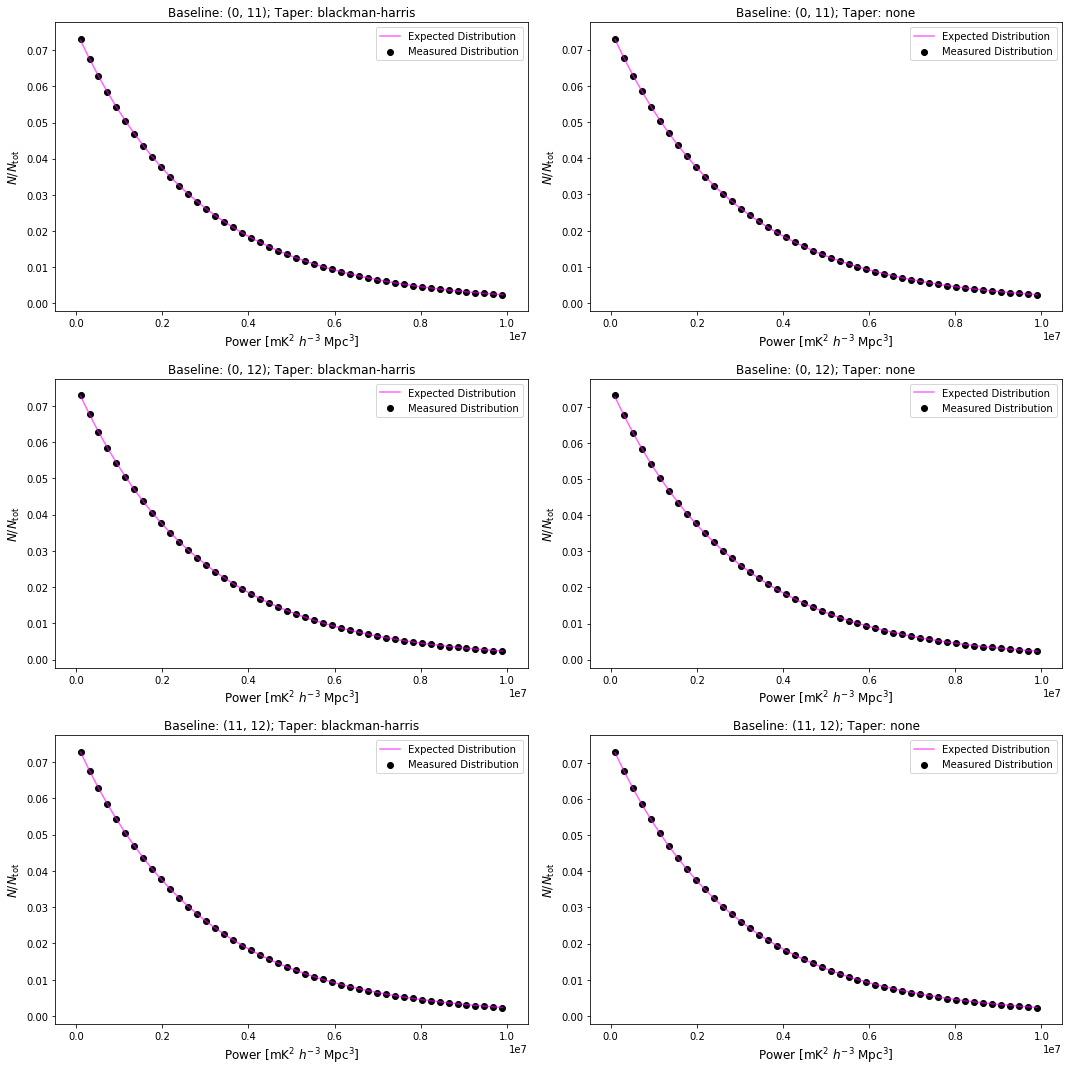

In [10]:
# calculate an exponential distribution using the bins from earlier and the power
# spectrum expected amplitude. normalize it by using .sum() on the array. plot the
# histograms on top of the exponential distribution.
powers = 0.5*(bins[1:] + bins[:-1])
exp_dist = np.exp(-powers/P0)
normed_exp = exp_dist/exp_dist.sum()

# make plots
fig = plt.figure(figsize=(15,15))
axes = fig.subplots(3,2)
for j, bl in enumerate(bls):
    for k, taper in enumerate(tapers):
        # label axes
        axes[j,k].set_xlabel(r'Power [mK$^2$ $h^{-3}$ Mpc$^3$]', fontsize=12)
        axes[j,k].set_ylabel(r'$N/N_\mathrm{tot}$', fontsize=12)
        axes[j,k].set_title('Baseline: {}; Taper: {}'.format(bl, taper))
        
        # plot exponential distribution first
        axes[j,k].plot(powers, normed_exp, color='magenta', alpha=0.6, label='Expected Distribution')
        
        # plot measured distribution
        axes[j,k].scatter(powers, hist[k,j], color='k', marker='o', label='Measured Distribution')
        
        # add a legend
        axes[j,k].legend(loc='upper right')
        
# show the figure
plt.tight_layout()
plt.show()

**Figure 2 |** Plots detailing the distribution of estimated powers. Each histogram was computed over the entire ensemble of power spectrum estimates, on a per-baseline and per-taper basis. The magenta line overplotted is an exponential distribution with scale parameter given by the expected power spectrum amplitude, normalized so that the sum of the distribution is unity.